In [1]:
!pip install konlpy

# 네이버 영화 리뷰 데이터를 이용해 분류 모델 작성
import numpy as np
import pandas as pd
import re
from konlpy.tag import Okt
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks  import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
train_data = pd.read_table("https://raw.githubusercontent.com/jangjungkeon/Study/main/Data/dataset/ratings_train.txt")
test_data = pd.read_table("https://raw.githubusercontent.com/jangjungkeon/Study/main/Data/dataset/ratings_test.txt")
print(train_data[:3], len(train_data))  # 150000
print(test_data[:3], len(test_data))    # 50000
print(train_data.columns)
# imsi = train_data.sample(n=1000, random_state=123)
# print(imsi)

         id                           document  label
0   9976970                아 더빙.. 진짜 짜증나네요 목소리      0
1   3819312  흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나      1
2  10265843                  너무재밓었다그래서보는것을추천한다      0 150000
        id                                document  label
0  6270596                                     굳 ㅋ      1
1  9274899                    GDNTOPCLASSINTHECLUB      0
2  8544678  뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아      0 50000
Index(['id', 'document', 'label'], dtype='object')


146182 49157
146182
{0, 1}


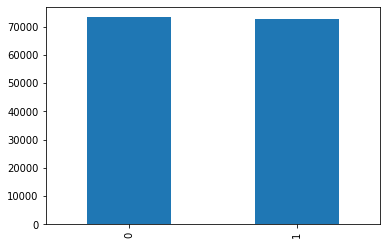

label
0    73342
1    72841
dtype: int64


In [3]:
# 데이터 전처리
print(train_data['document'].nunique(), test_data['document'].nunique())    # 146182 49157

train_data.drop_duplicates(subset=['document'], inplace=True)
print(train_data['document'].nunique())   # 146182
print(set(train_data['label']))     # {0 부정, 1 긍정}

# 0, 1이 어느정도 비율인지 시각화
train_data['label'].value_counts().plot(kind='bar')
plt.show()

print(train_data.groupby('label').size())   # 0: 73342, 1: 72841

In [4]:
# 결측치 확인
print(train_data.isnull().any())
print(train_data.isnull().sum())  # document에 1개의 결측치 존재. 

print(train_data.loc[train_data.document.isnull()]) # 25857  2172111      NaN      1

train_data = train_data.dropna(how='any')
print(train_data.isnull().values.any())
print(len(train_data))    # 146182

# 순수 한글 관련 자료 이외의 구둣점 등은 제거 
print(train_data[:3])
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎ ㅏ-ㅣ 가-힣]", "")
print(train_data[:3])

train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

train_data = train_data.dropna(how='any')
print(train_data.isnull().values.any())
print(len(train_data))    # 146182개에서 145791개

id          False
document     True
label       False
dtype: bool
id          0
document    1
label       0
dtype: int64
            id document  label
25857  2172111      NaN      1
False
146182
         id                           document  label
0   9976970                아 더빙.. 진짜 짜증나네요 목소리      0
1   3819312  흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나      1
2  10265843                  너무재밓었다그래서보는것을추천한다      0
         id                    document  label
0   9976970           아 더빙 진짜 짜증나네요 목소리      0
1   3819312  흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나      1
2  10265843           너무재밓었다그래서보는것을추천한다      0
id            0
document    391
label         0
dtype: int64
False
145791


In [5]:
# test
test_data.drop_duplicates(subset=['document'], inplace=True)
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎ ㅏ-ㅣ 가-힣]", "")
test_data['document'].replace('', np.nan, inplace=True)
test_data = test_data.dropna(how="any")
print(test_data.isnull().sum())
print(len(test_data))   # 48995

id          0
document    0
label       0
dtype: int64
48995


In [ ]:
# 불용어 제거
a = "아,휴,아이구,아이쿠,아이고,어,나,우리,저희,따라,의해,을,를,에,의,가,으로,로,에게,뿐이다,의거하여,근거하여,입각하여,기준으로,예하면,예를 들면,예를 들자면,저,소인,소생,저희,지말고,하지마,하지마라,다른,물론,또한,그리고,비길수 없다,해서는 안된다,뿐만 아니라,만이 아니다,만은 아니다,막론하고,관계없이,그치지 않다,그러나,그런데,하지만,든간에,논하지 않다,따지지 않다,설사,비록,더라도,아니면,만 못하다,하는 편이 낫다,불문하고,향하여,향해서,향하다,쪽으로,틈타,이용하여,타다,오르다,제외하고,이 외에,이 밖에,하여야,비로소,한다면 몰라도,외에도,이곳,여기,부터,기점으로,따라서,할 생각이다,하려고하다,이리하여,그리하여,그렇게 함으로써,하지만,일때,할때,앞에서,중에서,보는데서,으로써,로써,까지,해야한다,일것이다,반드시,할줄알다,할수있다,할수있어,임에 틀림없다,한다면,등,등등,제,겨우,단지,다만,할뿐,딩동,댕그,대해서,대하여,대하면,훨씬,얼마나,얼마만큼,얼마큼,남짓,여,얼마간,약간,다소,좀,조금,다수,몇,얼마,지만,하물며,또한,그러나,그렇지만,하지만,이외에도,대해 말하자면,뿐이다,다음에,반대로,반대로 말하자면,이와 반대로,바꾸어서 말하면,바꾸어서 한다면,만약,그렇지않으면,까악,툭,딱,삐걱거리다,보드득,비걱거리다,꽈당,응당,해야한다,에 가서,각,각각,여러분,각종,각자,제각기,하도록하다,와,과,그러므로,그래서,고로,한 까닭에,하기 때문에,거니와,이지만,대하여,관하여,관한,과연,실로,아니나다를가,생각한대로,진짜로,한적이있다,하곤하였다,하,하하,허허,아하,거바,와,오,왜,어째서,무엇때문에,어찌,하겠는가,무슨,어디,어느곳,더군다나,하물며,더욱이는,어느때,언제,야,이봐,어이,여보시오,흐흐,흥,휴,헉헉,헐떡헐떡,영차,여차,어기여차,끙끙,아야,앗,아야,콸콸,졸졸,좍좍,뚝뚝,주룩주룩,솨,우르르,그래도,또,그리고,바꾸어말하면,바꾸어말하자면,혹은,혹시,답다,및,그에 따르는,때가 되어,즉,지든지,설령,가령,하더라도,할지라도,일지라도,지든지,몇,거의,하마터면,인젠,이젠,된바에야,된이상,만큼어찌됏든,그위에,게다가,점에서 보아,비추어 보아,고려하면,하게될것이다,일것이다,비교적,좀,보다더,비하면,시키다,하게하다,할만하다,의해서,연이서,이어서,잇따라,뒤따라,뒤이어,결국,의지하여,기대여,통하여,자마자,더욱더,불구하고,얼마든지,마음대로,주저하지 않고,곧,즉시,바로,당장,하자마자,밖에 안된다,하면된다,그래,그렇지,요컨대,다시 말하자면,바꿔 말하면,즉,구체적으로,말하자면,시작하여,시초에,이상,허,헉,허걱,바와같이,해도좋다,해도된다,게다가,더구나,하물며,와르르,팍,퍽,펄렁,동안,이래,하고있었다,이었다,에서,로부터,까지,예하면,했어요,해요,함께,같이,더불어,마저,마저도,양자,모두,습니다,가까스로,하려고하다,즈음하여,다른,다른 방면으로,해봐요,습니까,했어요,말할것도 없고,무릎쓰고,개의치않고,하는것만 못하다,하는것이 낫다,매,매번,들,모,어느것,어느,로써,갖고말하자면,어디,어느쪽,어느것,어느해,어느 년도,라 해도,언젠가,어떤것,어느것,저기,저쪽,저것,그때,그럼,그러면,요만한걸,그래,그때,저것만큼,그저,이르기까지,할 줄 안다,할 힘이 있다,너,너희,당신,어찌,설마,차라리,할지언정,할지라도,할망정,할지언정,구토하다,게우다,토하다,메쓰겁다,옆사람,퉤,쳇,의거하여,근거하여,의해,따라,힘입어,그,다음,버금,두번째로,기타,첫번째로,나머지는,그중에서,견지에서,형식으로 쓰여,입장에서,위해서,단지,의해되다,하도록시키다,뿐만아니라,반대로,전후,전자,앞의것,잠시,잠깐,하면서,그렇지만,다음에,그러한즉,그런즉,남들,아무거나,어찌하든지,같다,비슷하다,예컨대,이럴정도로,어떻게,만약,만일,위에서 서술한바와같이,인 듯하다,하지 않는다면,만약에,무엇,무슨,어느,어떤,아래윗,조차,한데,그럼에도 불구하고,여전히,심지어,까지도,조차도,하지 않도록,않기 위하여,때,시각,무렵,시간,동안,어때,어떠한,하여금,네,예,우선,누구,누가 알겠는가,아무도,줄은모른다,줄은 몰랏다,하는 김에,겸사겸사,하는바,그런 까닭에,한 이유는,그러니,그러니까,때문에,그,너희,그들,너희들,타인,것,것들,너,위하여,공동으로,동시에,하기 위하여,어찌하여,무엇때문에,붕붕,윙윙,나,우리,엉엉,휘익,윙윙,오호,아하,어쨋든,만 못하다하기보다는,차라리,하는 편이 낫다,흐흐,놀라다,상대적으로 말하자면,마치,아니라면,쉿,그렇지 않으면,그렇지 않다면,안 그러면,아니었다면,하든지,아니면,이라면,좋아,알았어,하는것도,그만이다,어쩔수 없다,하나,일,일반적으로,일단,한켠으로는,오자마자,이렇게되면,이와같다면,전부,한마디,한항목,근거로,하기에,아울러,하지 않도록,않기 위해서,이르기까지,이 되다,로 인하여,까닭으로,이유만으로,이로 인하여,그래서,이 때문에,그러므로,그런 까닭에,알 수 있다,결론을 낼 수 있다,으로 인하여,있다,어떤것,관계가 있다,관련이 있다,연관되다,어떤것들,에 대해,이리하여,그리하여,여부,하기보다는,하느니,하면 할수록,운운,이러이러하다,하구나,하도다,다시말하면,다음으로,에 있다,에 달려 있다,우리,우리들,오히려,하기는한데,어떻게,어떻해,어찌됏어,어때,어째서,본대로,자,이,이쪽,여기,이것,이번,이렇게말하자면,이런,이러한,이와 같은,요만큼,요만한 것,얼마 안 되는 것,이만큼,이 정도의,이렇게 많은 것,이와 같다,이때,이렇구나,것과 같이,끼익,삐걱,따위,와 같은 사람들,부류의 사람들,왜냐하면,중의하나,오직,오로지,에 한하다,하기만 하면,도착하다,까지 미치다,도달하다,정도에 이르다,할 지경이다,결과에 이르다,관해서는,여러분,하고 있다,한 후,혼자,자기,자기집,자신,우에 종합한것과같이,총적으로 보면,총적으로 말하면,총적으로,대로 하다,으로서,참,그만이다,할 따름이다,쿵,탕탕,쾅쾅,둥둥,봐,봐라,아이야,아니,와아,응,아이,참나,년,월,일,령,영,일,이,삼,사,오,육,륙,칠,팔,구,이천육,이천칠,이천팔,이천구,하나,둘,셋,넷,다섯,여섯,일곱,여덟,아홉,령,영"
stopwords = a.split(",")
print(stopwords)

# 형태소 분류
okt = Okt()
x_train = []
for sen in train_data['document']:
  imsi = []
  imsi = okt.morphs(sen, stem=True)     # 행복
  imsi = [word for word in imsi if not word in stopwords]
  x_train.append(imsi)

print(x_train[:3])

x_test = []
for sen in test_data['document']:
  imsi = []
  imsi = okt.morphs(sen, stem=True)     # 행복
  imsi = [word for word in imsi if not word in stopwords]
  x_test.append(imsi)

print(x_test[:3])

['아', '휴', '아이구', '아이쿠', '아이고', '어', '나', '우리', '저희', '따라', '의해', '을', '를', '에', '의', '가', '으로', '로', '에게', '뿐이다', '의거하여', '근거하여', '입각하여', '기준으로', '예하면', '예를 들면', '예를 들자면', '저', '소인', '소생', '저희', '지말고', '하지마', '하지마라', '다른', '물론', '또한', '그리고', '비길수 없다', '해서는 안된다', '뿐만 아니라', '만이 아니다', '만은 아니다', '막론하고', '관계없이', '그치지 않다', '그러나', '그런데', '하지만', '든간에', '논하지 않다', '따지지 않다', '설사', '비록', '더라도', '아니면', '만 못하다', '하는 편이 낫다', '불문하고', '향하여', '향해서', '향하다', '쪽으로', '틈타', '이용하여', '타다', '오르다', '제외하고', '이 외에', '이 밖에', '하여야', '비로소', '한다면 몰라도', '외에도', '이곳', '여기', '부터', '기점으로', '따라서', '할 생각이다', '하려고하다', '이리하여', '그리하여', '그렇게 함으로써', '하지만', '일때', '할때', '앞에서', '중에서', '보는데서', '으로써', '로써', '까지', '해야한다', '일것이다', '반드시', '할줄알다', '할수있다', '할수있어', '임에 틀림없다', '한다면', '등', '등등', '제', '겨우', '단지', '다만', '할뿐', '딩동', '댕그', '대해서', '대하여', '대하면', '훨씬', '얼마나', '얼마만큼', '얼마큼', '남짓', '여', '얼마간', '약간', '다소', '좀', '조금', '다수', '몇', '얼마', '지만', '하물며', '또한', '그러나', '그렇지만', '하지만', '이외에도', '대해 말하자면', '뿐이다', '다음에', '반대로', '반대로 말하자면', '이와 반대로',

In [ ]:
# 워드 임베딩
tok = Tokenizer()
tok.fit_on_texts(x_train)
print(tok.word_index)

# 등장 빈도수를 확인해서 비중이 적은 자료는 배제
threshold = 3
total_cnt = len(tok.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

for k, v  in tok.word_counts.items():
  total_freq += v
  if v < threshold:
    rare_cnt += 1
    rare_freq += v

print('total_cnt : ', total_cnt)      # 43758
print('rare_cnt : ', rare_cnt)        # 24337
print('rare_freq : ', (rare_cnt / total_cnt) * 100)   # 55.617
print('total_cnt : ', (rare_freq / total_freq) * 100)   # 1.701, 2회 이하인 단어 전체 비중 1.7% 이므로. 
# OOV(out of vocab) : 단어 사전에 없으면 index 자체를 할 수 없게 되는데 이런 문제를 OOV 라고 함. 
vocab_size= total_cnt - rare_cnt + 2
print('vocab_size 크기 : ', vocab_size)     # 19423

tok = Tokenizer(vocab_size, oov_token='OOV')
tok.fit_on_texts(x_train)
x_train  = tok.texts_to_sequences(x_train)
x_test  = tok.texts_to_sequences(x_test)
print(x_train[:3])

y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [ ]:
# 비어 있는 샘플은 제거
drop_train = [index for index, sen in enumerate(x_train) if len(sen) < 1]

x_train  =  np.delete(x_train, drop_train, axis=0)
y_train  =  np.delete(y_train, drop_train, axis=0)
print(len(x_train), ' ', len(y_train))      # 145363   145363

print('리뷰 최대 길이 : ', max(len(i) for i in x_train))    # 75
print('리뷰 평균 길이 : ', sum(map(len, x_train)) / len(x_train))   # 12.101

plt.hist([len(s) for s in  x_train], bins=50)
plt.show()

In [ ]:
# 전체 샘플 중에서 길이가 max_len 이하인 샘플 비율이 몇 %인지 확인 함수 작성
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if len(s) <=  max_len:
      cnt += 1
  print('전체 샘플 중에서 길이가 %s 이하인 샘플 비율 : %s' %(max_len, (cnt  / len(nested_list)) * 100))

max_len = 30
below_threshold_len(max_len, x_train)      # 92% 정도가 30 이하의 길이를 가짐

x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)
print(x_train[:10])

In [ ]:
# 모델
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128, activation='tanh'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('tfrnn13.h5',  monitor='val_acc', mode="max", save_best_only=True)   # save_best_only=True, 좋아질때만 저장
history = model.fit(x_train, y_train, epochs=10, callbacks=[es, mc], batch_size=64, validation_split=0.2)


In [ ]:
# 저장된 모델로 나머지 작업
from tensorflow.keras.models import load_model
loaded_model = load_model('tfrnn13.h5')
print('acc : ', loaded_model.evaluate(x_test, y_test)[1])
print('loss : ', loaded_model.evaluate(x_test, y_test)[0])

# 예측
def new_pred(new_sentence):
  new_sentence = okt.morphs(new_sentence, stem=True)
  new_sentence = [word for word in new_sentence if not word in stopwords]
  encoded = tok.texts_to_sequences([new_sentence])
  pad_new = pad_sequences(encoded, maxlen=max_len)
  pred = float(loaded_model.predict(pad_new))
  if pred > 0.5:
    print("{:2f}% 확률로 긍정!".format(pred*100))
  else:
    print("{:2f}% 확률로 부정! ㅠㅠ".format((1 - pred)*100))

new_pred('영화가 재미있네요')
new_pred('심하다 지루하고 졸려')
new_pred('주인공이 너무 멋있어 추천하고 싶네요')
new_pred('히말라야의 소국  부탄이 신종 코로나바이러스 감염증')